# Cell transfer across ST slides of multiple time points

Multiple ST tissue sections obtained at different timepoints offer a valuable opportunity to gain a deeper understanding of cell transitions during organ development, such as mouse midbrain development and zebrafish embryogenesis. spaTrack can provide a novel strategy to infer cell tracing across multiple tissue sections based on an unbalanced and structured optimal transport algorithm by direct mapping cells among samples without integrating data. This approach is designed for cases where multiple sections containing the same cell types.In this tutorial, We use mouse midbrain ST data to demonstrate cell transfer across ST slides of multiple time points

In [1]:
import spaTrack as spt
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0
plt.rcParams['figure.dpi'] = 200 #分辨率

## 1.Prepare ST data

Spatial transcriptmic data of mouse midbrain at E12.5,E14.5 and E16.5 time points were downloaded from published paper(Chen et al.2022, Cell). The example of expression tsv file and additional information file in this part can be download from [Baidu Netdisk](https://pan.baidu.com/s/1Gpz7G0wx1nuol9610TAkXg?pwd=i4zv) and [Google Drive](https://drive.google.com/file/d/1YwlitZUc1RJ4304X15cCztTOwYZm3aX0/view?usp=sharing) .We focused on progenitors cells including RGC(radial glia cells),NeuB(neuroblasts) and GlioB(glioblasts) to describe transfer relations among these progenitors cells.

In [2]:
adata_all=sc.read('../data/mouse.midbrain.three.time/mouse midbrain.three.time.point.ST.exp.tsv')
df_annot=pd.read_table('../data/mouse.midbrain.three.time/meta.tsv',sep='\t',index_col=[0])
adata_all.obs=df_annot
adata_all.obsm['spatial']=adata_all.obs[['x','y']].values
adata_all.obs['CellID']=adata_all.obs.index

In [3]:
adata_all.obs

,annotation,Time point,x,y,batch,CellID
CELL.100034_1,RGC,E12.5,2829.000000,-10000.000000,0,CELL.100034_1
CELL.100795_1,RGC,E12.5,2893.000000,-9946.500000,0,CELL.100795_1
CELL.100841_1,RGC,E12.5,2672.000000,-9944.000000,0,CELL.100841_1
CELL.100867_1,RGC,E12.5,2728.000000,-9943.000000,0,CELL.100867_1
CELL.100880_1,RGC,E12.5,2927.000000,-9939.000000,0,CELL.100880_1
...,...,...,...,...,...,...
CELL.6735_2,RGC,E16.5,15004.779109,-9776.156045,2,CELL.6735_2
CELL.6758_2,RGC,E16.5,15347.769034,-9814.194334,2,CELL.6758_2
CELL.6761_2,RGC,E16.5,14462.674882,-9730.735710,2,CELL.6761_2
CELL.6909_2,RGC,E16.5,14620.735216,-9886.102795,2,CELL.6909_2


In [4]:
adata1_sub=adata_all[adata_all.obs['Time point']=='E12.5']
adata2_sub=adata_all[adata_all.obs['Time point']=='E14.5']
adata3_sub=adata_all[adata_all.obs['Time point']=='E16.5']
adata_all.uns['annotation_colors']=['#9A154C', '#F3754E', '#5B58A7']

Visualzation of mouse midbrain ST data of three time points

Text(0.5, 1.0, 'spatial')

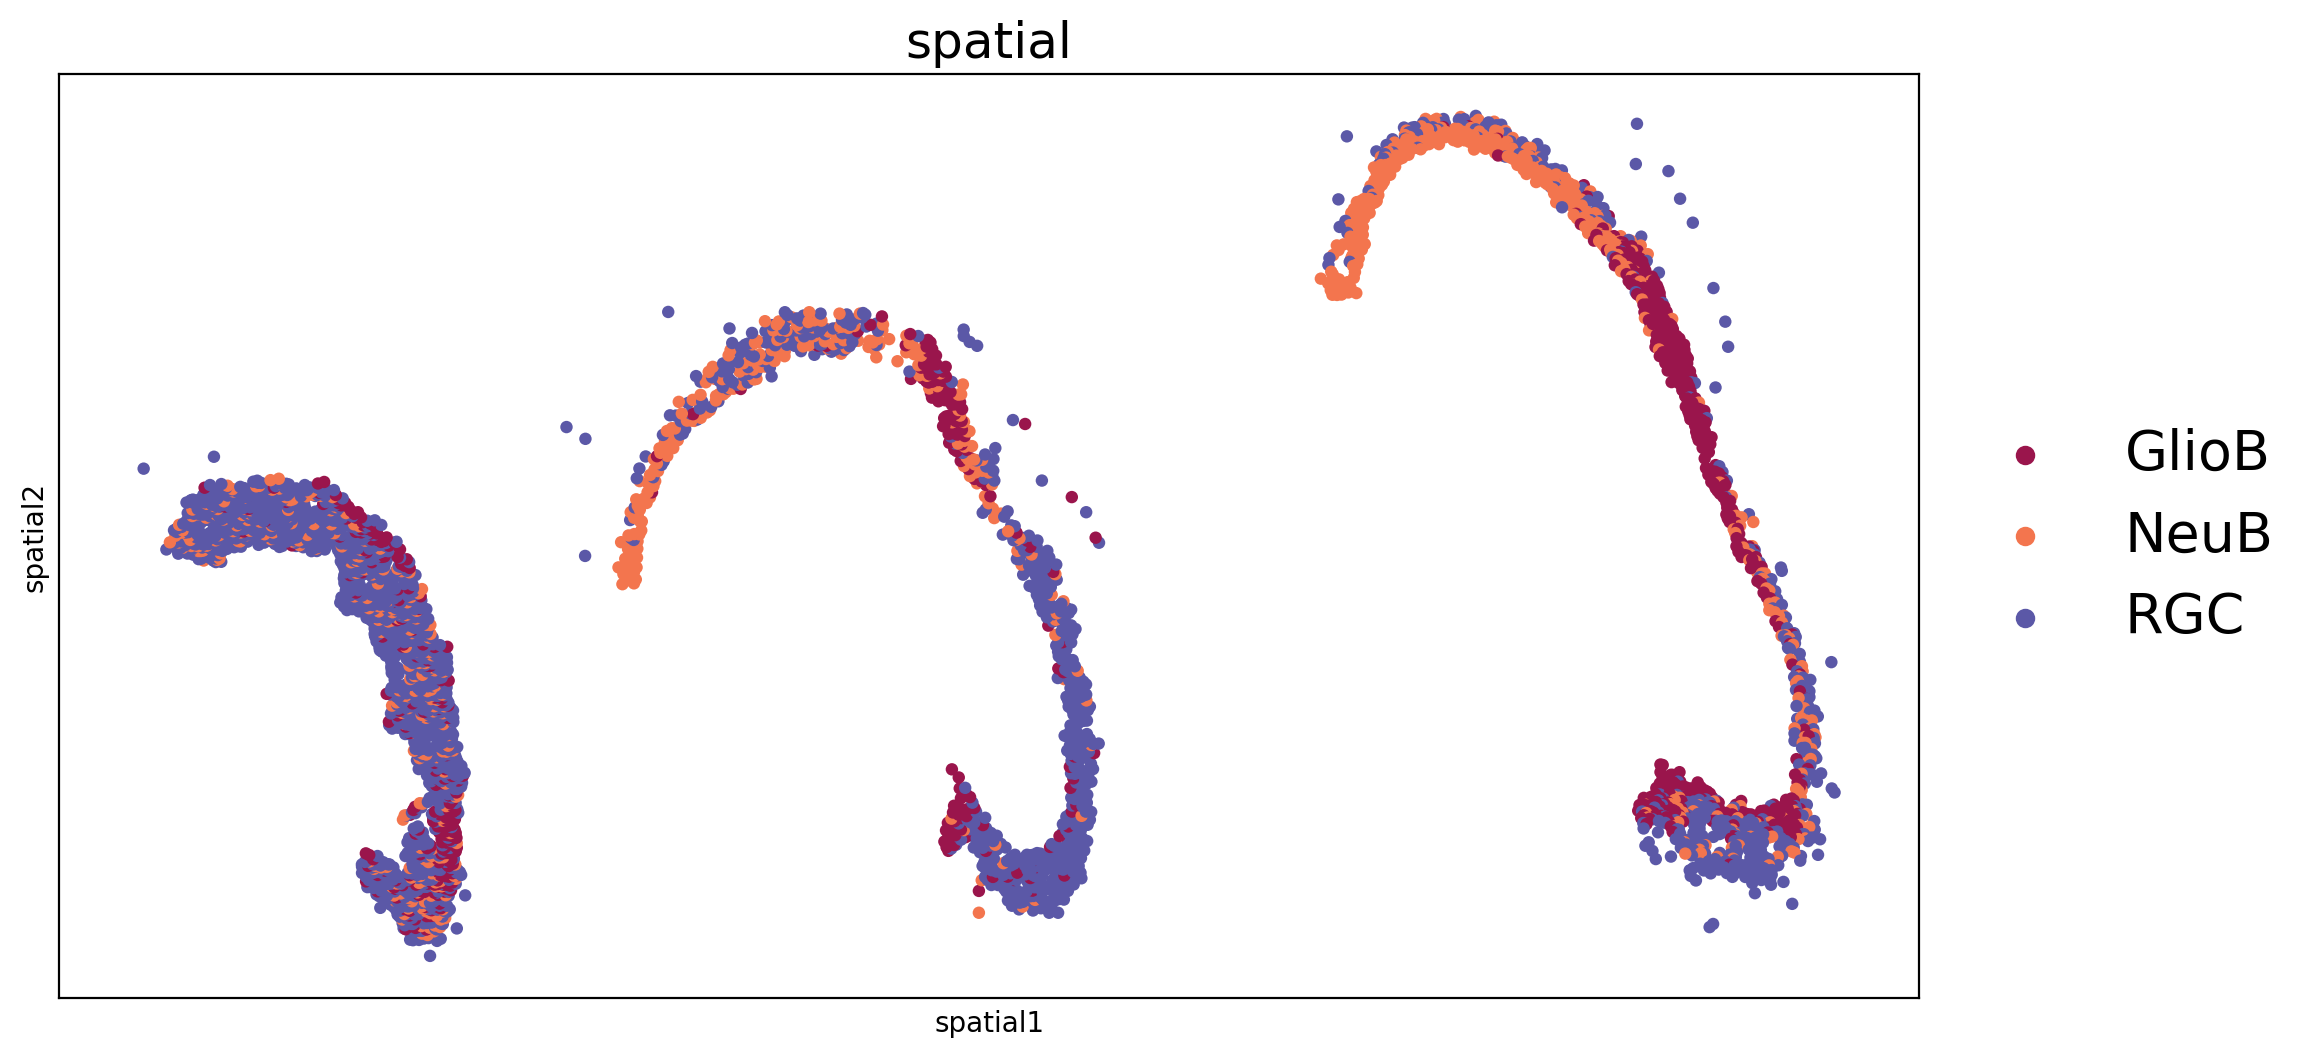

In [5]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(12, 6))
sc.pl.embedding(adata_all, basis='spatial', color='annotation', size=50, legend_loc='right margin', legend_fontsize=20,ax=axs, legend_fontoutline=3, show=False, s=80)
axs.set_title('spatial',fontsize=18)

## 2.Calculate transition probability across sections

 spaTrack infers cell tracing across multiple ST sections based on an unbalanced and structured optimal transport algorithm. We can calculate the transfer matrix between two ST sections using the spt.transfer_matrix function. Additionally, the transition probability between two sections can be calculated using spt.map_data. To obtain complete results across multiple sections, spt.generate_animate_input was used to integrate the transition probability results.


In [6]:
pi12 = spt.transfer_matrix(adata1_sub,adata2_sub,epsilon=0.01,alpha=0.2)
pi23 = spt.transfer_matrix(adata2_sub,adata3_sub,epsilon=0.01,alpha=0.2)

Save the file containing cell  transition probability between section 1(adata1_sub) and section 2(adata2_sub)

The object “pi_matrix_coord” contains comprehensive results from multiple sections. In the dataframe, First three columns represent the CellID in slice1, slice2, and slice3 with the maximum transition probability among them. The pi_value1 represents the maximum transition probability value between the CellID in slice1 and slice2. Similarly, the pi_value2 represents the maximum transition probability value between the CellID in slice2 and slice3. The k_line and b_line represent slopes and intercepts of lines connecting two cells used by spt.animate_transfer() function to display dynamic figure. Users have the option to filter the maximum transition probability values based on their distribution.

In [7]:
pi_matrix_coord = spt.generate_animate_input(pi_list=[pi12,pi23], adata_list=[adata1_sub,adata2_sub,adata3_sub],time ='Time point',annotation='annotation')
# pi_matrix_coord=pi_matrix_coord.loc[(pi_matrix_coord['pi_value1']> value1) & (pi_matrix_coord['pi_value1']> value2) ]

pi_matrix_coord.to_csv("./cell.transfer.csv")

In [8]:
pi_matrix_coord.head()

,slice1,slice2,slice3,slice1_annotation,slice2_annotation,slice3_annotation,slice1_x,slice2_x,slice3_x,slice1_y,slice2_y,slice3_y,k_line_12,b_line_12,k_line_23,b_line_23,pi_value1,pi_value2
0,CELL.100034_1,CELL.174282_3,CELL.6090_2,RGC,GlioB,RGC,2829.0,7709.0,14163.004072,-10000.0,-9508.0,-9438.505655,0.100820,-10285.218852,0.010768,-9591.007680,0.000142,0.000312
1,CELL.105208_1,CELL.174282_3,CELL.6090_2,RGC,GlioB,RGC,2275.0,7709.0,14163.004072,-9688.0,-9508.0,-9438.505655,0.033125,-9763.358852,0.010768,-9591.007680,0.000064,0.000312
2,CELL.100795_1,CELL.180259_3,CELL.2379_2,RGC,NeuB,NeuB,2893.0,5985.0,12882.097282,-9946.5,-7767.0,-7144.136505,0.704884,-11985.728169,0.090308,-8307.493756,0.000068,0.000261
3,CELL.116813_1,CELL.180259_3,CELL.2379_2,RGC,NeuB,NeuB,1092.0,5985.0,12882.097282,-8539.0,-7767.0,-7144.136505,0.157776,-8711.291845,0.090308,-8307.493756,0.000178,0.000261
4,CELL.117907_1,CELL.180259_3,CELL.2379_2,RGC,NeuB,NeuB,659.0,5985.0,12882.097282,-8383.0,-7767.0,-7144.136505,0.115659,-8459.219302,0.090308,-8307.493756,0.000165,0.000261


## 3.Visualze cell transfer by dynamic figure

Animation of cell transferation

In [9]:
# spt.animate_transfer(adata_list=[adata1_sub,adata2_sub,adata3_sub],
#                  transfer_path='./cell.transfer.csv',
#                  fig_title = " 'RGC' transfer from E12.5 E14.5 to E16.5",
#                  time ='Time point',
#                  annotation='annotation',
#                  save_path='./cell.transfer.html',
#                  times=['E12.5','E14.5','E16.5'])

![](../_static/230718.gif)

## 4.Visualize cell transfer by 3D figure

Preparation of input data.

In [10]:
df_adata_1=adata1_sub.obs[['CellID','annotation','x','y']]
df_adata_1['batch']='slice1'
df_adata_2=adata2_sub.obs[['CellID','annotation','x','y']]
df_adata_2['batch']='slice2'
df_adata_3=adata3_sub.obs[['CellID','annotation','x','y']]
df_adata_3['batch']='slice3'
df_concat=pd.concat([df_adata_1,df_adata_2,df_adata_3])

df_mapping_cell=pi_matrix_coord[['slice1','slice2','slice3']]

We can visualize the three sections and the line cells with the maximum transition probability in a 3D space.

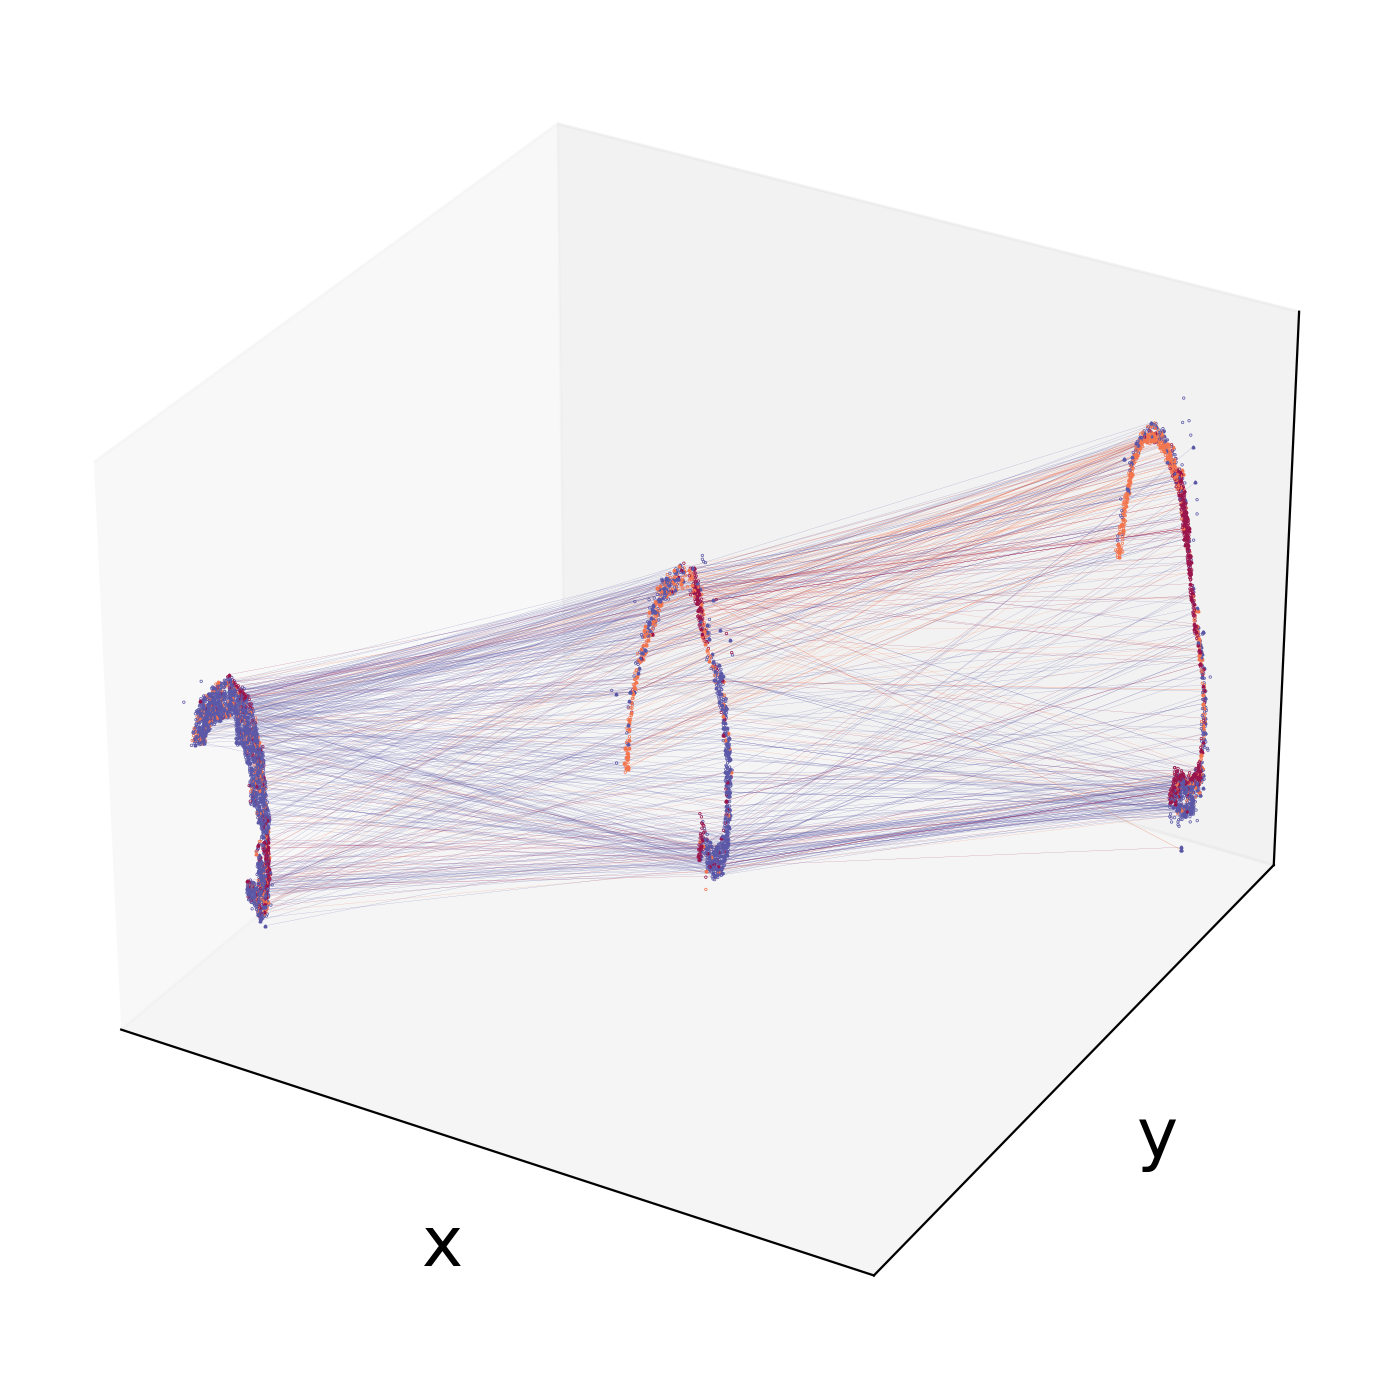

In [11]:
spt.visual_3D_mapping_3(df_concat,df_mapping_cell,point_size=0.8,line_width=0.06,cell_color_list=['#9A154C', '#F3754E', '#5B58A7'])

We can visualize specific two consecutive sections after calculating the transition probability across the sections.

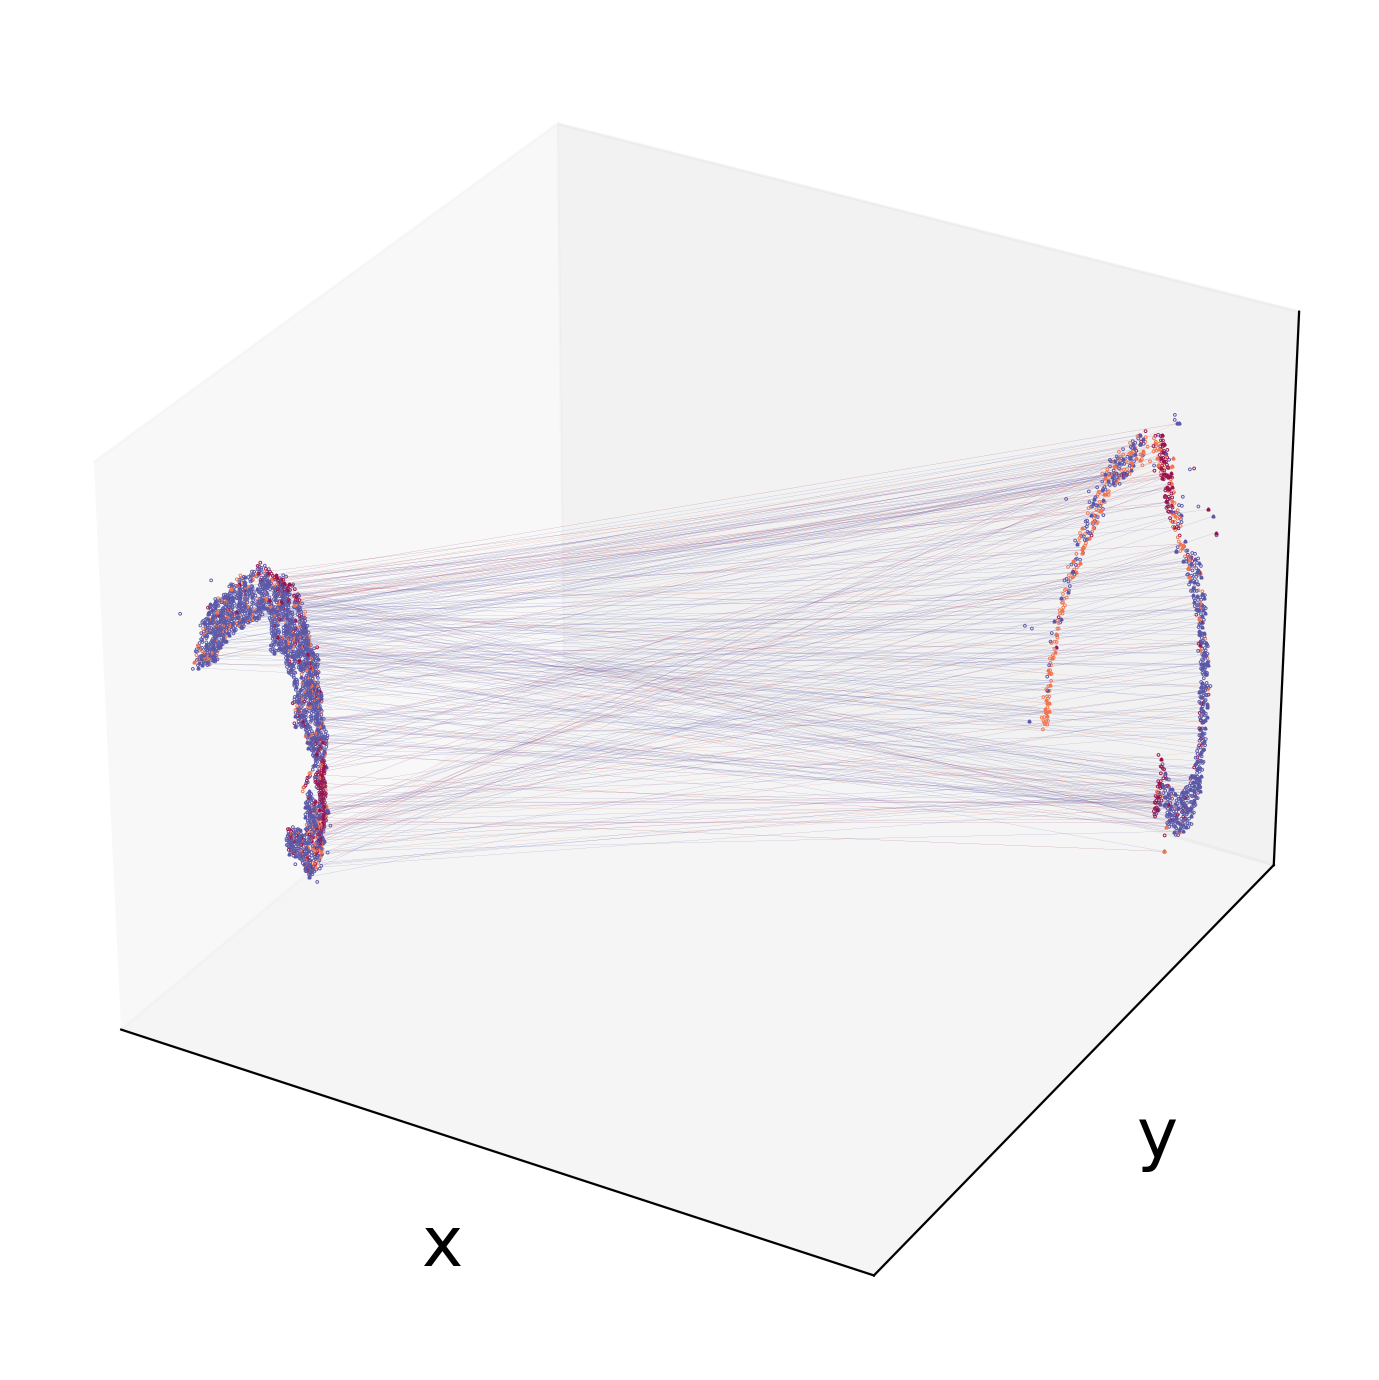

In [12]:
spt.visual_3D_mapping_2(df_concat,df_mapping_cell[['slice1','slice2']],point_size=1,line_width=0.05,cell_color_list=['#9A154C', '#F3754E', '#5B58A7'])

## 5.Construct gene regulation network

Here, we use adata from E12.5 and E14.5 as an example to construct regulatory network between TF genes and target genes inferred along the developmental trajectory between two time points.TF genes list of mouse or human can be download from [the link](https://github.com/yzf072/spaTrack/tree/main/spaTrack/example.data).

In [13]:
adata1_sub.write('./E12.5.adata.h5ad')
adata2_sub.write('./E14.5.adata.h5ad')

In [14]:
pi_df=spt.map_data(pi12,adata1_sub,adata2_sub)
pi_df.to_csv('./cell_mapping.csv')

In [15]:
gr = spt.Trainer(
    data_type='2_time',
    expression_matrix_path=['./E12.5.adata.h5ad','./E14.5.adata.h5ad'],
    cell_mapping_path='./cell_mapping.csv',
    tfs_path='../data/mouse.midbrain.three.time/ms.TF.tsv', 
    min_cells=[50,20],
    cell_generate_per_time=10000,
    cell_select_per_time=50
)

gr.run(training_times=10,iter_times=30)

Train 10: 100%|██████████| 300/300 [05:30<00:00,  1.10s/it, train_loss=0.0147, test_loss=0.016] 


Weight relationships of tfs and genes are stored in weights.csv.


Show the relationship between TF and target genes by scatter diagram.

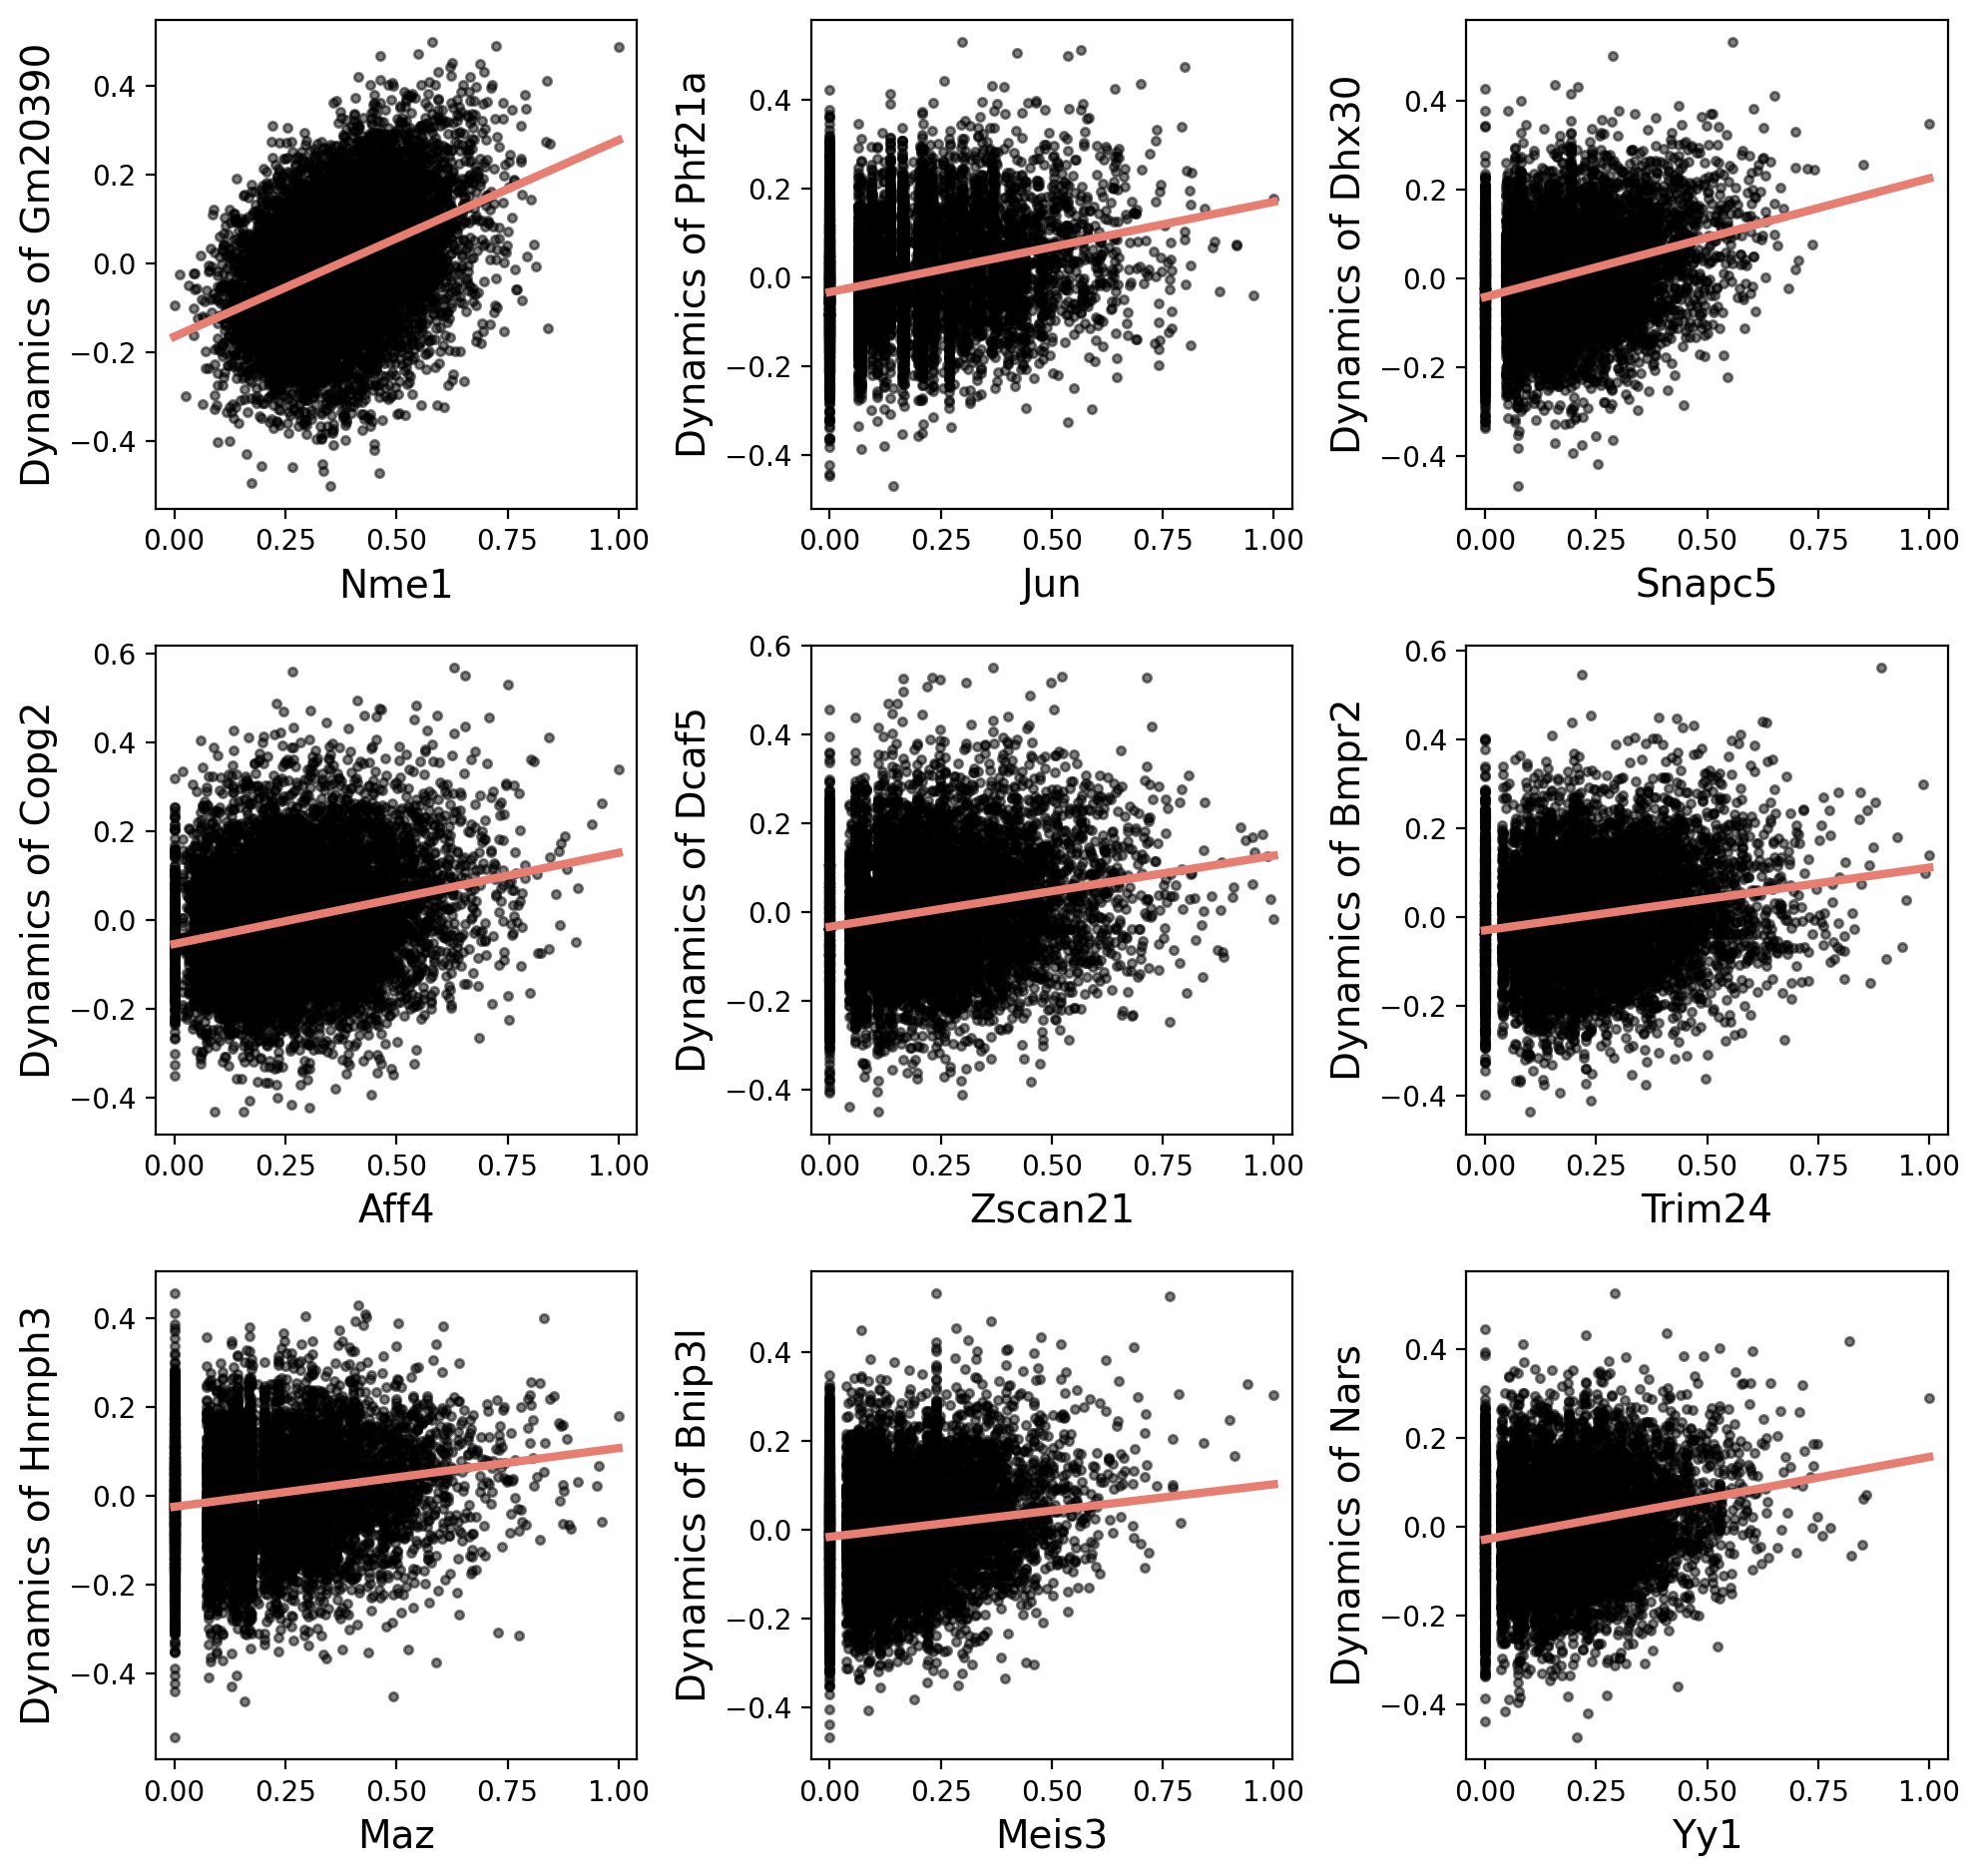

In [16]:
gr.plot_scatter()

Get weights between TFs and genes.

In [17]:
gr.network_df

,TF,gene,weight
387,Nme1,Gm20390,0.026246
2517,Jun,Phf21a,0.019388
2267,Snapc5,Dhx30,0.018995
215,Aff4,Copg2,0.018846
1757,Zscan21,Dcaf5,0.018819
...,...,...,...
1493,Foxp1,Zic3,0.010581
180,Rbm7,G3bp1,0.010579
588,Ybx1,Ttr,0.010579
2289,Abcf2,1810013L24Rik,0.010578


Plot the gene regulatory network diagram according to the `'gr.network_df'`.

num of weight pairs after weight filtering: 1112
num of weight pairs after node_count filtering: 65


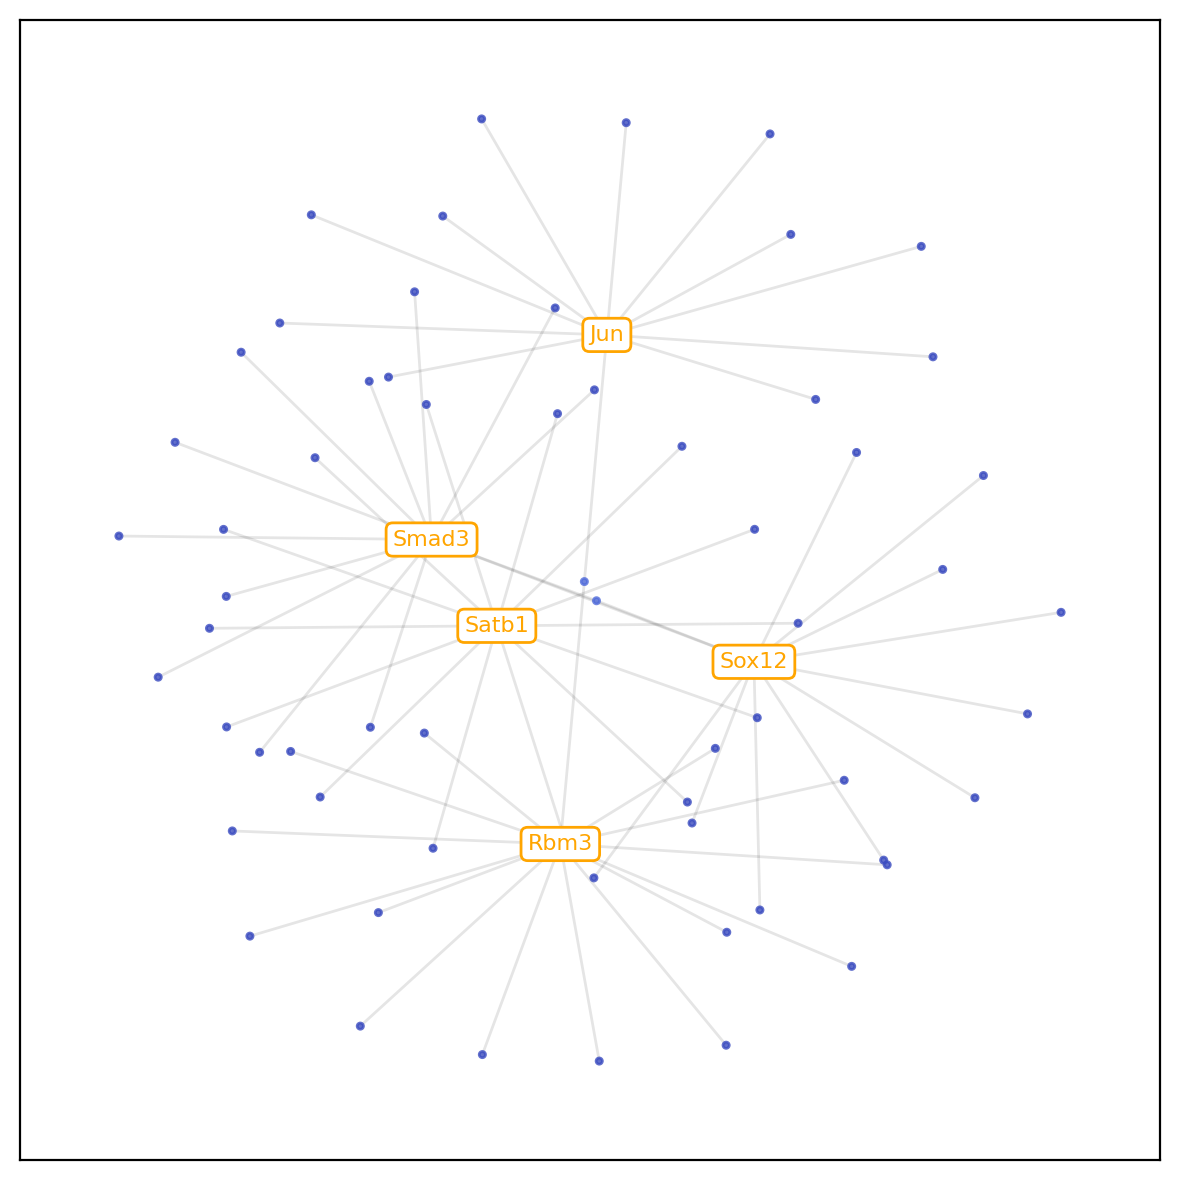

In [18]:
gr.plot_gene_regulation(min_weight=0.012,min_node_num=12)